In [7]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [8]:
import mne
from pprint import pprint
import json
import csv
import numpy as np

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 524287  =      0.000 ...   511.999 secs...
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 06:53:38 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_new_noNotched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_new_noNotched.fif
[done]


/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/1317057165.py:28: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_new_noNotched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  n_MMN_raw.save(fif_DIR / Path('eeg_20250610_test_new_noNotched.fif'), overwrite=True)


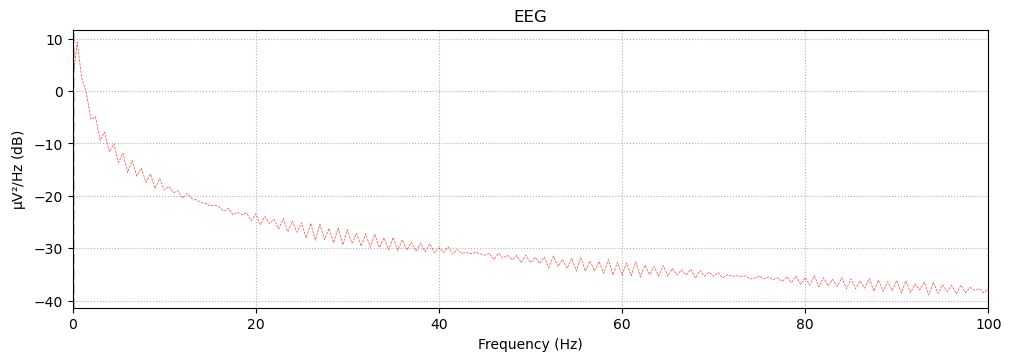

Channels marked as bad:
['Trigger']


In [82]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_new_Notched.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

n_MMN_raw.compute_psd(fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
fif_DIR.mkdir(exist_ok=True)

n_MMN_raw.save(fif_DIR / Path('eeg_20250610_test_new_noNotched.fif'), overwrite=True)

In [83]:
n_MMN_raw.plot_psd(fmax=100)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)


ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [84]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq)), (end_tNDarray[i][0]/int(raw_sfreq)))
    cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[  8744      0      1]
 [ 68651      0      3]
 [144131      0     11]
 [146165      0      2]
 [209144      0      4]
 [278897      0     11]
 [280916      0      8]
 [346966      0      5]
 [357762      0     11]
 [359970      0      9]
 [432166      0      6]
 [439272      0     11]
 [441476      0     10]
 [510597      0      7]
 [520315      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[  8744      0      1]
 [146165      0      2]
 [280916      0      8]
 [359970      0      9]
 [441476      0     10]]
5
[[144131      0     11]
 [278897      0     11]
 [357762      0     11]
 [439272      0     11]
 [520315      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeClose_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_L

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/HEOG_60count_new_Notched.fif
[done]
431.12890625 508.1201171875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

In [3]:
# Calculate the power spectrum density to examine the power in each frequency.
spectrum = n_MMN_raw.compute_psd()
spectrum.plot(picks='Fz_1', average=True, amplitude=False) #, exclude="bads", amplitude=False)

Effective window size : 2.000 (s)


ValueError: picks ('Fz_1') could not be interpreted as channel names (no channel "['Fz_1']"), channel types (no type "Fz_1" present), or a generic type (just "all" or "data")

Channels marked as bad:
['Trigger']


In [14]:
n_MMN_raw.load_data().notch_filter(freqs=60)#.filter(0, 30, phase='zero-double').resample(500). #raw.notch_filter(freqs=60)  # US/Canada
picks = mne.pick_types(n_MMN_raw.info, eeg=True, eog=True, exclude='bads')
n_MMN_raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6759 samples (6.601 s)

Using pyopengl with version 3.1.1a1


Channels marked as bad:
['Trigger']
Channels marked as bad:
['Trigger']


In [25]:
## We don't do ICA when it's only one channel involved ##
# ICA
#ica = mne.preprocessing.ICA(n_components=15, random_state=97)
#ica.fit(n_MMN_raw, picks=picks)
#ica_

#Plot ICA
#ica_.plot_sources(n_MMN_raw)
#ica_.plot_components()#sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 5])  # 5 3 2 1

In [24]:
"""
# Checking for every component
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_LDT_raw, exclude=[i])
"""

'\n# Checking for every component\nfor i in range(15):\n    #ica_.plot_properties(n_raw, picks=[i])\n    ica_.plot_overlay(n_LDT_raw, exclude=[i])\n'

In [23]:
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 1, 3, 7])
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 1, 2, 4])

In [26]:
"""
# ICAed epochs
# excluding wanted components
ica_.exclude = [0, 1, 2, 4]
ica_.plot_overlay(n_LDT_raw, exclude=ica_.exclude)

ica_.apply(n_LDT_raw) #changes the Raw object in-place, so let's make a copy first:
#n_LDT_raw.plot()
"""

"\n# ICAed epochs\n# excluding wanted components\nica_.exclude = [0, 1, 2, 4]\nica_.plot_overlay(n_LDT_raw, exclude=ica_.exclude)\n\nica_.apply(n_LDT_raw) #changes the Raw object in-place, so let's make a copy first:\n#n_LDT_raw.plot()\n"

In [82]:
n_LDT_raw.save(raw_ICAed_path / Path('S%.3d_rawLDT_ICAed.fif' %sub_id), overwrite=True)

Writing /Users/neuroling/Downloads/DINGHSIN_Results/LTTC_MEG/LTTC_MEG_ALL_results/LTTC_rawLDT_ICAed_fif/S007_rawLDT_ICAed.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_23625/766722599.py:1: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/LTTC_MEG/LTTC_MEG_ALL_results/LTTC_rawLDT_ICAed_fif/S007_rawLDT_ICAed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  n_LDT_raw.save(raw_ICAed_path / Path('S%.3d_rawLDT_ICAed.fif' %sub_id), overwrite=True)


Closing /Users/neuroling/Downloads/DINGHSIN_Results/LTTC_MEG/LTTC_MEG_ALL_results/LTTC_rawLDT_ICAed_fif/S007_rawLDT_ICAed.fif
[done]


In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())
